# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 1. Camera Calibration

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import os

In [2]:
# load camera calibration image
camera_dir = './camera_cal/'
camera_files = [camera_dir + w for w in os.listdir(camera_dir)]

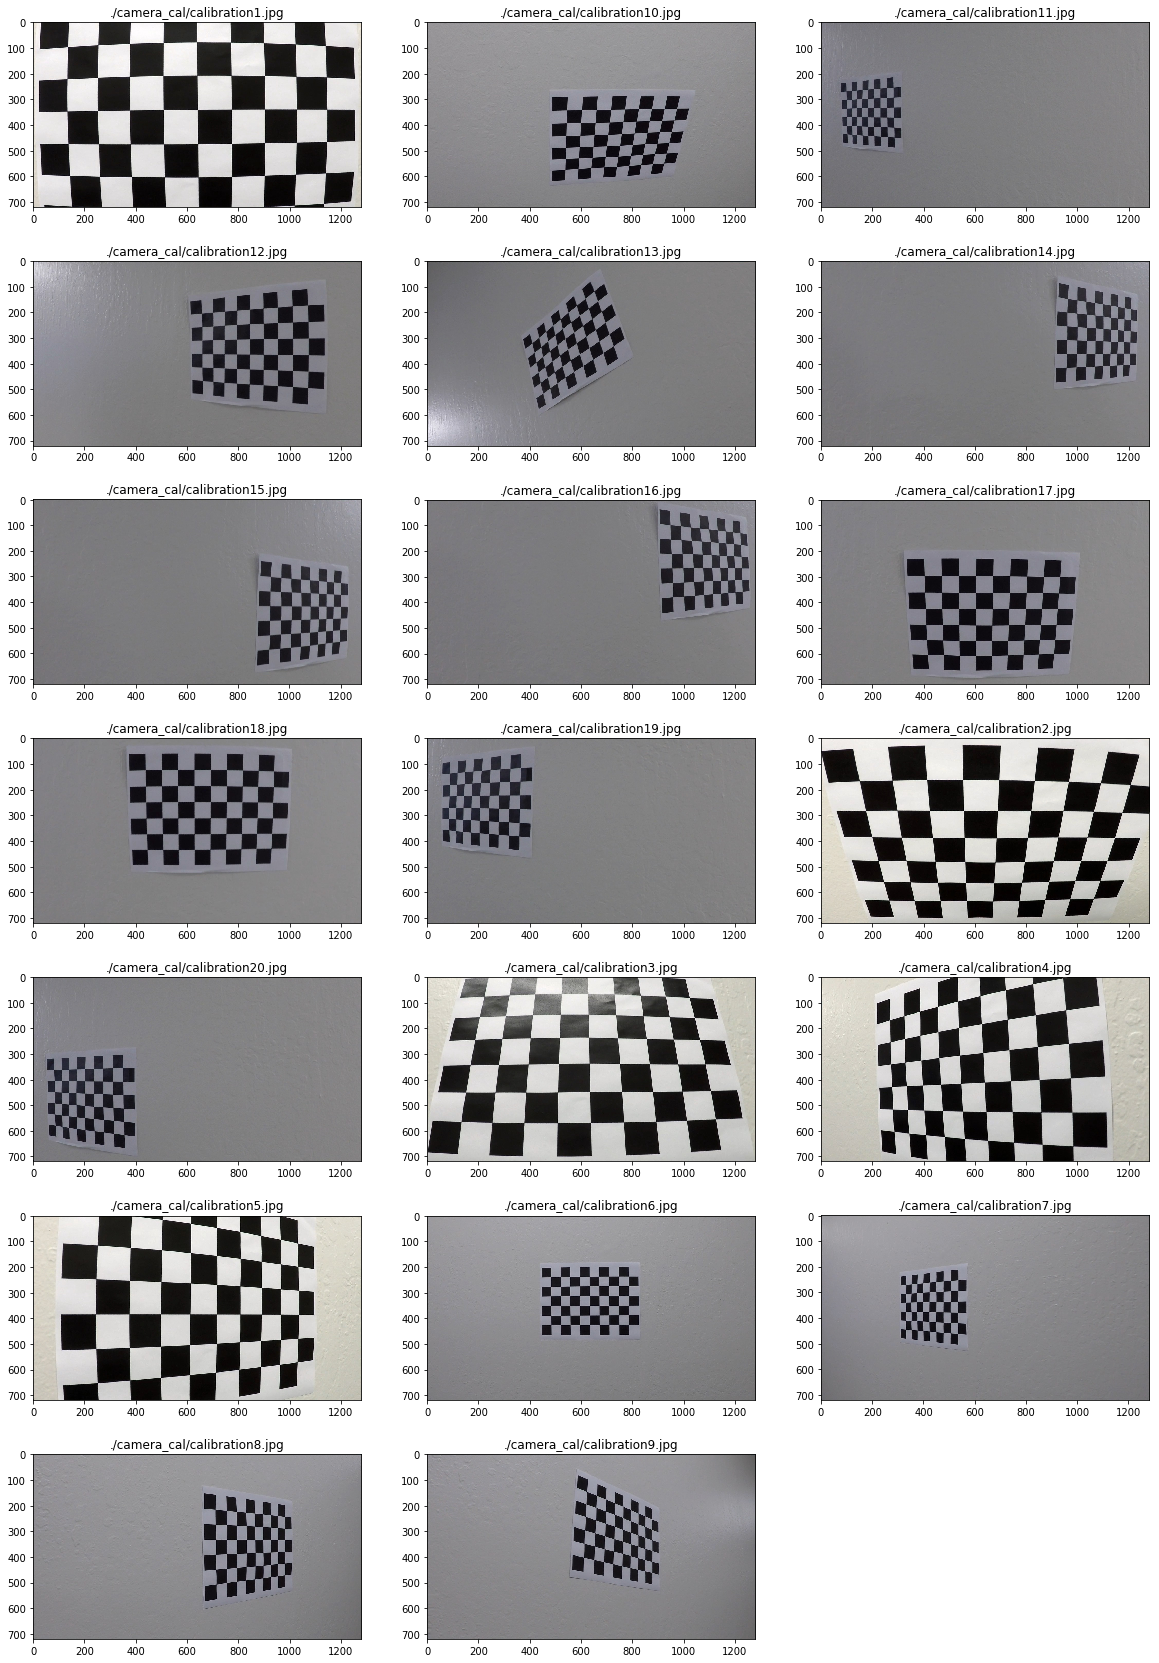

In [3]:
count = 0
#plt.figure()
plt.figure(figsize=(20,30))
for filename in camera_files:
    img = mpimg.imread(filename)
    count +=1
    plt.subplot(7,3,count)
    plt.imshow(img)    
    plt.title(filename)

For each uncalibrated image with a chessboard, we first convert it to a gray image and then find the corners of the chessboard. 

- We first try to find corners among the following sizes according to the order of the list: [(9,6), (9,5), (8,6), (8,5), (7,6), (7,5), (6,6), (5,6)], and will return the corners the first time that cv2.findChessboardCorners is able to find them.
- We then map each of the corners to a point in a rectangular grid. We collect all the corners and the mapped points.
- We then calculate the calibration parameter using cv2.calibrateCamera function.
- We then undistort the first image using the calibrated parameters

In [4]:
def find_corners(img_gray, candidate_sizes):
    for corner_size in candidate_sizes:
        retval, corners = cv2.findChessboardCorners(img_gray, corner_size, None)
        if retval:
            return retval, corners, corner_size
    if not retval:
        return retval, None, None

The located corners are shown below for each image. If corners are not found, then the original image is shown. 

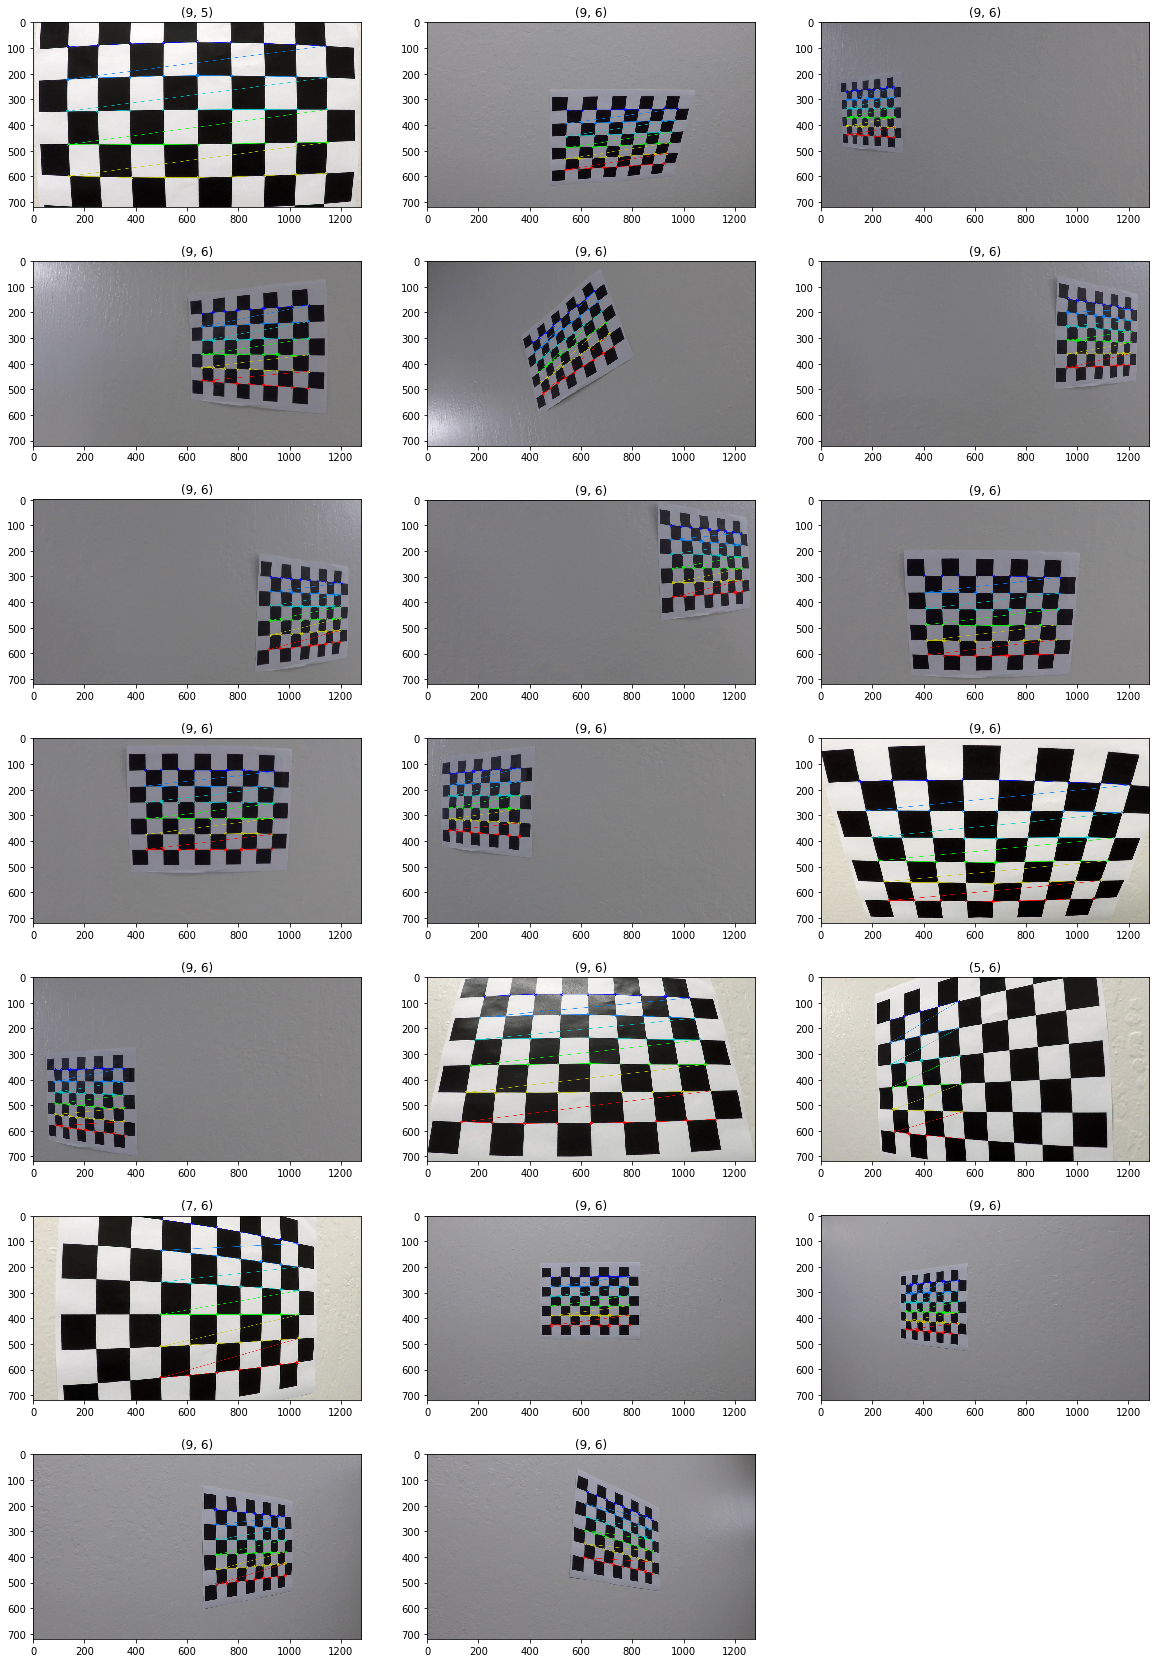

In [5]:
obj_points = []
src_points = []
count = 0
plt.figure(figsize=(20,30))
for filename in camera_files:
    count +=1
    img = mpimg.imread(filename)
    # load image
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # find corners
    retval, corners, corner_size = find_corners(img_gray, [(9,6), (9,5), (8,6), (8,5), (7,6), (7,5), (6,6), (5,6)])
    
    plt.subplot(7,3,count)
    if retval:        
        img_with_lines = cv2.drawChessboardCorners(img.copy(), corner_size, corners, retval)                
        plt.imshow(img_with_lines)
        plt.title(corner_size)
        obj_array = np.concatenate([np.mgrid[0:corner_size[0],0:corner_size[1]].T.reshape(-1,2),
                                    np.zeros((corner_size[0]*corner_size[1],1))], axis=1).astype(np.float32)        
        obj_points.append(obj_array)
        src_points.append(np.squeeze(corners))
    else:
        plt.imshow(img)
            
plt.savefig('./write_up_img/calibration_corners.jpg')

The test image and the undistorted version is shown below:

In [6]:
# return the calibration operation as a function to be used in future steps
def get_undistort_fun(mtx, dist):
    return lambda img: cv2.undistort(img.copy(), mtx, dist, None, mtx)

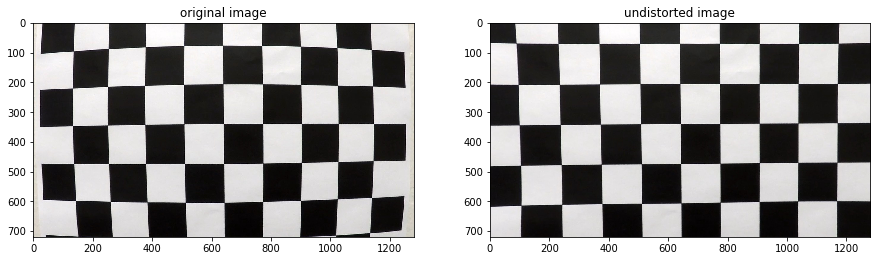

In [7]:
# find calibration parameters    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    obj_points,
    src_points,
    img_gray.shape[::-1], None, None)

pipline_undistort = get_undistort_fun(mtx, dist)

count = count +1
img = mpimg.imread('./camera_cal/calibration1.jpg')
undistorted = pipline_undistort(img)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(undistorted)
plt.title('undistorted image')
plt.savefig('./write_up_img/undistorted_image.jpg')

## 2. Single Image Lane Detection Pipeline

Use an image example, we build the pipeline to process a single image

In [8]:
test_dir = './test_images/'
test_files = os.listdir(test_dir)
filename = 'straight_lines1.jpg'
figsize=(20,8)
img = mpimg.imread(test_dir+filename)

### 2.1 Camera calibration
We apply the above calibration coefficient to undistort the test images:

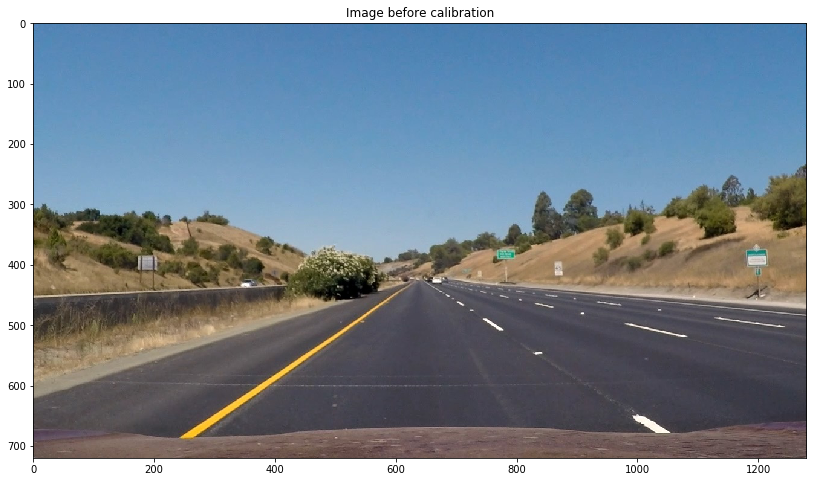

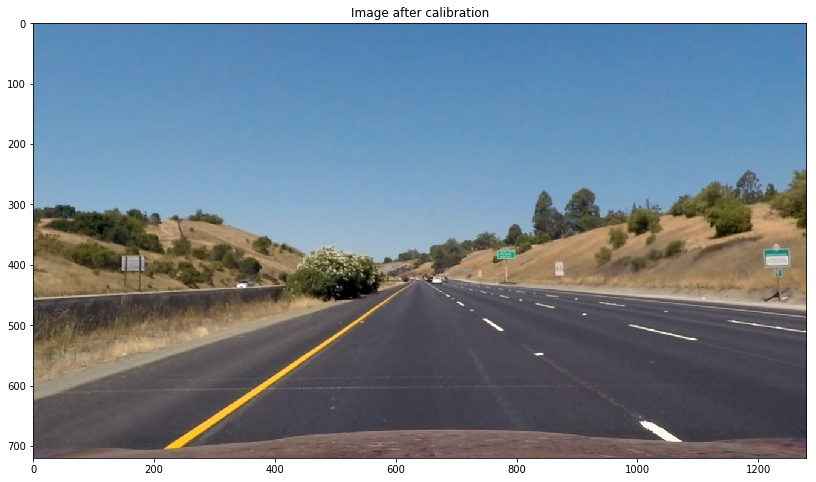

In [9]:
img_undistorted = pipline_undistort(img)
plt.figure(figsize=figsize);
plt.imshow(img);
plt.title('Image before calibration');
plt.show();
plt.figure(figsize=figsize);
plt.imshow(img_undistorted);
plt.title('Image after calibration');
plt.show();
plt.savefig('./write_up_img/image_pipeline/2_1_after_calibration.jpg');

### 2.2 Lane Detection

In [10]:
def draw_lines(img, lines, color=[255, 255, 0], thickness=2):
    """
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
def mag_gradient_thresh(image_single_channel, mag_thresh, ksize):    
    # calculate sobel gradient and appy threshold
    sobelx = cv2.Sobel(image_single_channel, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(image_single_channel, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    abs_sobelxy_percentage = abs_sobelxy/np.max(abs_sobelxy)
    # convert to binary image
    mask = np.zeros_like(abs_sobelxy_percentage)
    mask[(abs_sobelxy_percentage>=mag_thresh[0]) & (abs_sobelxy_percentage <= mag_thresh[1])]=1
    return mask
def dir_abs_gradient_thresh(image_single_channel, dir_thresh, ksize):
    #img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # calculate sobel gradient direction
    sobelx = cv2.Sobel(image_single_channel, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(image_single_channel, cv2.CV_64F, 0, 1, ksize=ksize)
    sobel_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # convert to binary image
    mask = np.zeros_like(sobel_dir)
    mask[(sobel_dir>=dir_thresh[0]) & (sobel_dir <= dir_thresh[1])]=1
    return mask, sobel_dir
def single_color_lane_detection(image_single_color, thresh, mag_thresh, dir_thresh, ksize, intermediate_image=False):
    # detect yellow lanes via LAB component B
    
    # edge detection
    image_mag = mag_gradient_thresh(image_single_color, mag_thresh, ksize)
    image_dir, sobel_dir = dir_abs_gradient_thresh(image_single_color, dir_thresh, ksize)                             
    image_gradient_binary = np.zeros_like(image_single_color)
    image_gradient_binary[np.logical_and(image_mag, image_dir)] = 1
    
    # color detection
    image_mag_binary = np.zeros_like(image_single_color)
    image_mag_binary[(image_single_color>=thresh[0]) & (image_single_color <= thresh[1])]=1
        
    #
    combined_binary = np.zeros_like(image_single_color)
    combined_binary[(image_gradient_binary==1) | (image_mag_binary==1)]=1
    if intermediate_image:
        img_illustration = np.dstack([np.zeros_like(image_mag_binary),
                                      image_gradient_binary,
                                      image_mag_binary]).astype(float)
        return combined_binary, img_illustration, image_single_color, image_mag, image_dir, image_gradient_binary, image_mag_binary, sobel_dir
    else:
        return combined_binary

In [11]:
def lane_pixel_detection(image, intermediate_image=False):
    if intermediate_image:
        yellow_binary, yellow_illustration, _, _, _, _, _, _ = (
            single_color_lane_detection(cv2.cvtColor(image, cv2.COLOR_RGB2LAB)[:,:,2],
                                        (160,255),
                                        (0.4, 1.0),
                                        (np.pi*35/180, np.pi*65/180),
                                        ksize=3,
                                        intermediate_image=True))
        white_binary, white_illustration, _, _, _, _, _, _ = (
            single_color_lane_detection(cv2.cvtColor(image, cv2.COLOR_RGB2LUV)[:,:,0],
                                        (210,255),
                                        (0.6, 1.0),
                                        (np.pi*35/180, np.pi*65/180),
                                        ksize=3,
                                        intermediate_image=True))    
        img_illustration = np.dstack([np.zeros_like(image[:,:,-1]),
                                      yellow_binary,
                                      white_binary]).astype(float)                                      
        image_binary = np.zeros_like(image[:,:,-1])
        image_binary[(yellow_binary==1) | (white_binary==1)]=1
        return image_binary, img_illustration, yellow_illustration, white_illustration
    else:
        yellow_binary = (
            single_color_lane_detection(cv2.cvtColor(image, cv2.COLOR_RGB2LAB)[:,:,2],
                                        (160,255),
                                        (0.4, 1.0),
                                        (np.pi*35/180, np.pi*65/180),
                                        ksize=3,
                                        intermediate_image=False))
        white_binary  = (
            single_color_lane_detection(cv2.cvtColor(image, cv2.COLOR_RGB2LUV)[:,:,0],
                                        (210,255),
                                        (0.6, 1.0),
                                        (np.pi*35/180, np.pi*65/180),
                                        ksize=3,
                                        intermediate_image=False))                                        
        image_binary = np.zeros_like(image[:,:,-1])
        image_binary[(yellow_binary==1) | (white_binary==1)]=1
        return image_binary

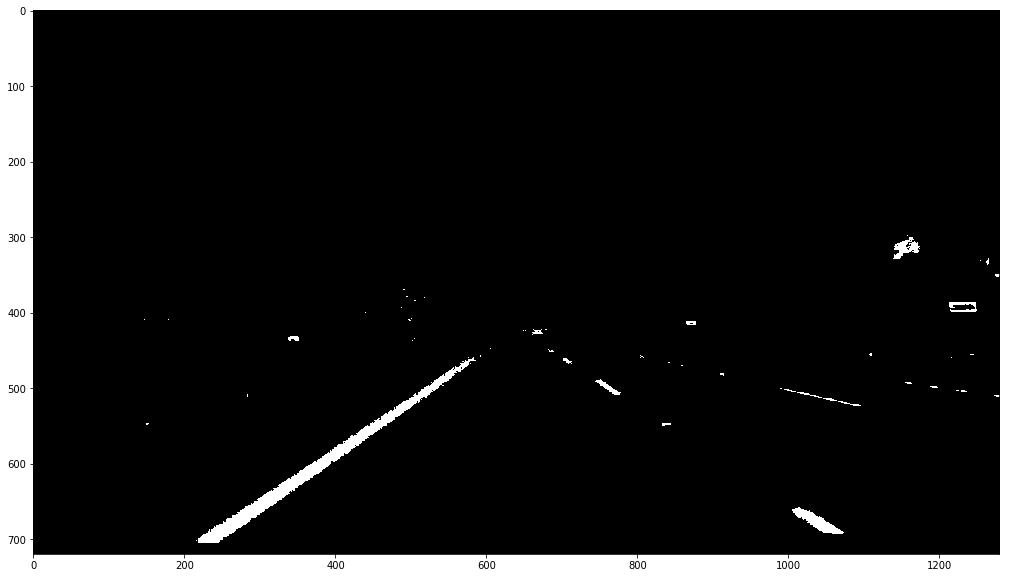

In [12]:
img_binary, img_illustration, yellow_illustration, white_illustration = lane_pixel_detection(img_undistorted,
                                                                                        intermediate_image=True)
plt.figure(figsize=(20,10))
plt.imshow(img_binary, 'gray')

### 2.3 Perspective Transform
To apply perspective transform, we use cv2. getPerspectiveTransform function by selecting 2 sets of 4 points in the image. 
To obtain these points, we use the basic lane detection algorithm in Project 1 to identify two adjacent lanes in the image and then manually select two horizontal lanes that intersects these two lanes. 
The functions from project 1 are contained in the project1_module.py

#### 2.3.1 Obtain perspective transform

In [13]:
src_points =  np.array([[  524., 500.],
                       [  763., 500.],
                       [  236., 700.],
                       [ 1071., 700.]]).astype(np.float32) 
delta_x = 100
dst_points = np.array([[  236.+delta_x, 450.],
                       [ 1071.-delta_x, 450.],
                       [  236.+delta_x, 700.],
                       [ 1071.-delta_x, 700.]]).astype(np.float32) 
M_perspective_transform = cv2.getPerspectiveTransform(src_points, dst_points)

In [14]:
img_src_points=img_undistorted.copy()
draw_lines(img_src_points, np.expand_dims(np.stack([np.concatenate([src_points[0],src_points[2]]),
                                                    np.concatenate([src_points[1],src_points[3]]),
                                                    np.concatenate([src_points[0],src_points[1]]),
                                                    np.concatenate([src_points[2],src_points[3]])], axis=0),
                                          axis=0),
           color=[0, 255, 0], thickness=2)
    
img_dst_points = cv2.warpPerspective(img_undistorted, M_perspective_transform, (img_undistorted.shape[1], img_undistorted.shape[0]))
draw_lines(img_dst_points, np.expand_dims(np.stack([np.concatenate([dst_points[0],dst_points[2]]),
                                            np.concatenate([dst_points[1],dst_points[3]]),
                                            np.concatenate([dst_points[0],dst_points[1]]),
                                            np.concatenate([dst_points[2],dst_points[3]])], axis=0),
                                  axis=0),
               color=[0, 255, 0], thickness=2)

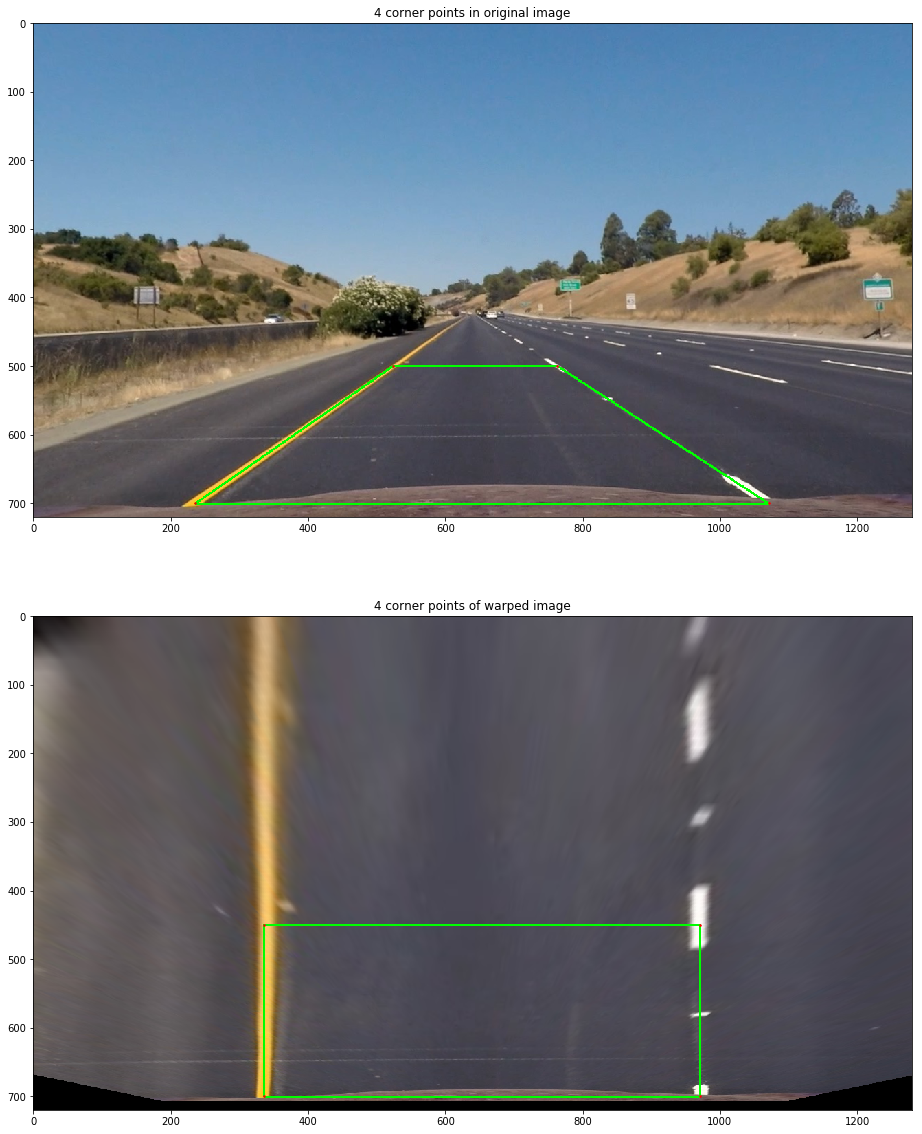

In [15]:
fig, axes = plt.subplots(2,1, figsize=(20,20))
axes[0].imshow(img_src_points)
for jj in range(0, src_points.shape[0]):
    axes[0].plot(src_points[jj,0], src_points[jj,1],'r.', markersize=3)
axes[0].set_title('4 corner points in original image')
axes[1].imshow(img_dst_points)
for jj in range(0, dst_points.shape[0]):
    axes[1].plot(dst_points[jj,0], dst_points[jj,1],'r.', markersize=3)
axes[1].set_title('4 corner points of warped image')
plt.savefig('./write_up_img/image_pipeline/2_3_illustration_perspective_transform.png')

#### 2.3.2 Apply Perspective Transform

In [16]:
img_warped = cv2.warpPerspective(img_undistorted, M_perspective_transform, (img_undistorted.shape[1], img_undistorted.shape[0]))                                 
img_warped_binary = cv2.warpPerspective(img_binary, M_perspective_transform, (img_binary.shape[1], img_binary.shape[0]))  

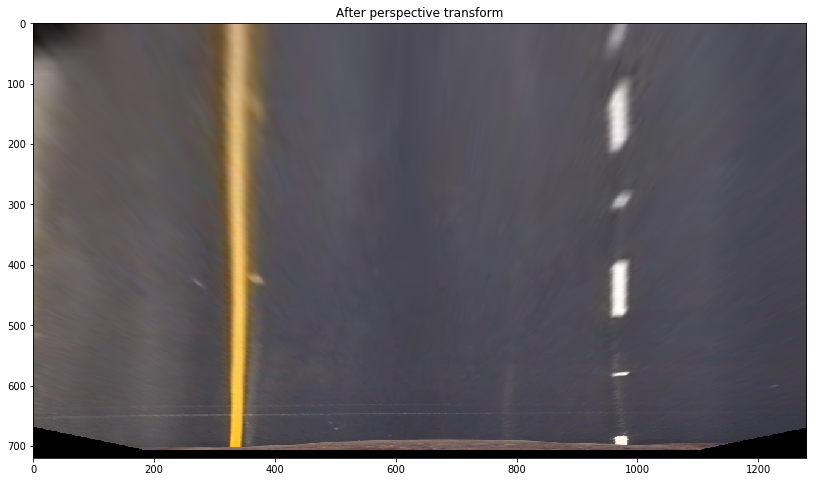

In [17]:
plt.figure(figsize=figsize)
plt.imshow(img_warped)
plt.title('After perspective transform')

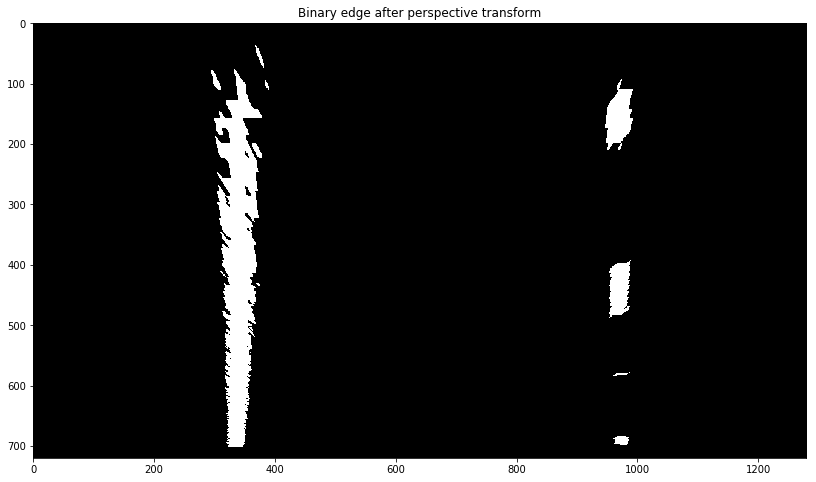

In [18]:
plt.figure(figsize=figsize)
plt.imshow(img_warped_binary, 'gray')
plt.title('Binary edge after perspective transform')

## 2.4 Lane Pixel Identification

In [19]:
from scipy import signal    

def get_lane_pixel_mask(image, threshold=100, window_height=21, window_width=101, y_min=0, y_max=700,half_search_width=100):
    half_window_width = int(window_width/2)
    half_window_height = int(window_height/2)    
    image_width = image.shape[1]
    window = np.ones((window_height, window_width))+np.tile(np.concatenate([np.arange(0, half_window_width), np.arange(half_window_width, -1, -1)]), (window_height,1)) /half_window_width 
    convoluted = signal.fftconvolve(image, window, 'same')
    
    #y_ = [w for w in range(y_max - half_window_height-1, y_min + half_window_height, -window_height)]
    window_center_y = []    
    window_center_x = []
    search_end_point = (half_window_width, image_width-half_window_width)
    
    for y in range(y_max - half_window_height-1, y_min + half_window_height, -window_height):
        center_x = np.clip(search_end_point[0] + np.argmax(convoluted[y, search_end_point[0]:search_end_point[1]]),
                           a_min= half_window_width,
                           a_max = image_width-half_window_width)                
                                                             
        if convoluted[y, center_x] >= threshold:
            search_end_point = (np.clip(center_x - half_search_width, a_min=0, a_max=image_width),
                                np.clip(center_x + half_search_width, a_min=0, a_max=image_width))
            window_center_y.append(np.arange(y-half_window_height + window_height-1, y-half_window_height-1, -1))
            window_center_x.append(np.repeat(center_x, window_height))
    if len(window_center_y)>=1:
        return np.concatenate(window_center_y), np.concatenate(window_center_x)
    else:
        return np.array([]), np.array([])
        

def get_pixel_index(image, window_center_y, window_center_x, half_window_width=50, x_offset=0):
    mask = np.zeros_like(image)
    for jj in range(len(window_center_y)):
        x = np.clip(window_center_x[jj], a_min=0, a_max = image.shape[0]-1)
        mask[window_center_y[jj], x-half_window_width:x+half_window_width+1] = (
            image[window_center_y[jj], x-half_window_width:x+half_window_width+1])
    lane_pixel_y, lane_pixel_x = mask.nonzero()   
    return lane_pixel_y, lane_pixel_x+x_offset


In [20]:
window_center_y, window_center_x = get_lane_pixel_mask(img_warped_binary[:, 0:int(img_warped_binary.shape[1]/2)])
left_y, left_x = get_pixel_index(img_warped_binary[:, 0:int(img_warped_binary.shape[1]/2)],
                                 window_center_y, window_center_x)

window_center_y, window_center_x = get_lane_pixel_mask(img_warped_binary[:, int(img_warped_binary.shape[1]/2):])
right_y, right_x = get_pixel_index(img_warped_binary[:, int(img_warped_binary.shape[1]/2):],
                                 window_center_y, window_center_x, x_offset=int(img_warped_binary.shape[1]/2))

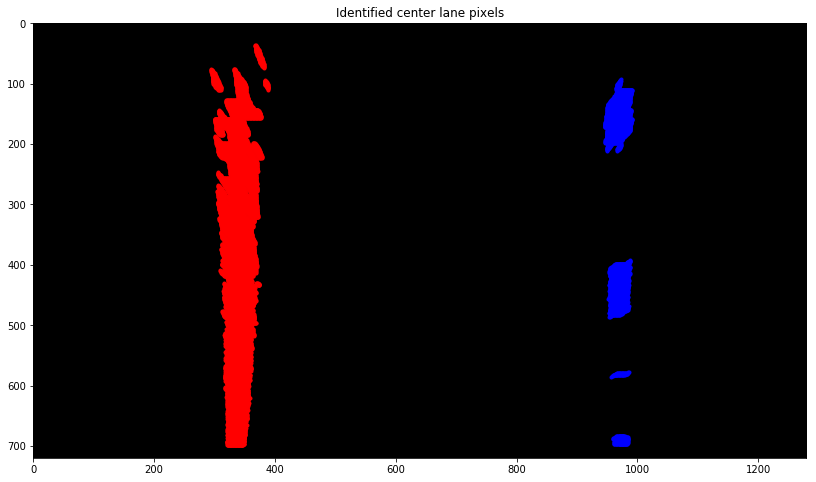

In [21]:
plt.figure(figsize=figsize)
plt.imshow(img_warped_binary, 'gray')
plt.plot(left_x, left_y,'r.')
plt.plot(right_x, right_y,'b.')
plt.title('Identified center lane pixels')

## 2.5 Fit Lane and Calculate Curvature

In [22]:
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols, rlm
def calc_curvature(x_pix, y_pix, ym_per_pix = 3/90, xm_per_pix = 3.7/635, y_car_pos=700):
     # meters per pixel in y dimension
     # meters per pixel in x dimension
    y=y_pix*ym_per_pix
    x=x_pix*xm_per_pix
    rlm_model = rlm('x~I(y**2)+y', data={'y':y, 'x':x}).fit()
    coefs = np.array([rlm_model.params['I(y ** 2)'], rlm_model.params['y'], rlm_model.params['Intercept']])
   
    Rcurve_car = (1+(2*y_car_pos*ym_per_pix*coefs[0]+coefs[1])**2)**(3.0/2)/np.abs(2*coefs[0])

    y_polyfit = np.arange(0,y_car_pos).astype(np.int32)
    x_polyfit = (rlm_model.predict({'y':y_polyfit*ym_per_pix})/xm_per_pix).astype(np.int32)
    return Rcurve_car, coefs[1], y_polyfit, x_polyfit.ravel(), x_polyfit.ravel()[-1], coefs



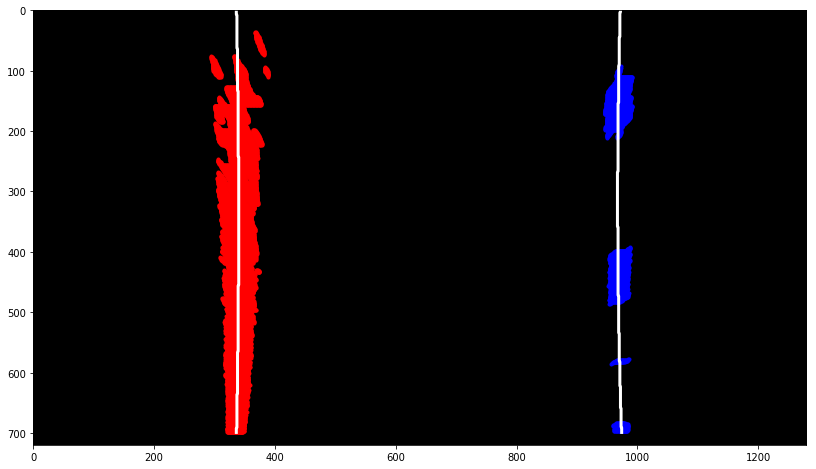

In [23]:
R_left, slope_left, left_lane_y, left_lane_x, left_lane_pos, _ = calc_curvature(left_x, left_y)
R_right, slope_right, right_lane_y, right_lane_x, right_lane_pos, _ = calc_curvature(right_x, right_y)

#Rright, y_right, x_right, right_lane_pos = get_curvature(lane_pixels_right, 700, 500)
x_car_pos = img_warped_binary.shape[1]/2 - (left_lane_pos+right_lane_pos)/2
plt.figure(figsize=figsize)
plt.imshow(img_warped_binary, 'gray')
plt.plot(left_x, left_y,'r.')
plt.plot(right_x, right_y,'b.')
plt.plot(left_lane_x, left_lane_y,'w', linewidth=3)
plt.plot(right_lane_x, right_lane_y,'w', linewidth=3)

#plt.figure(figsize=figsize)
#plt.imshow(img_warped_binary, 'gray')
#plt.plot(x_left, y_left,'r', linewidth=3)
#plt.plot(x_right, y_right,'g', linewidth=3)
#plt.title('Fitted lanes using single lane curvature fitting')
#plt.savefig('./write_up_img/image_pipeline/2_5_lane_single_fit.png')

## 2.6 Mark detected lane

In [24]:
# mask lanes on original image
def mark_unwarped_lane(image, M, x_left, y_left, x_right, y_right, width=5, rgb_color=None):
    lane_mask_warped = np.zeros_like(image)
    for y in y_left:
        lane_mask_warped[y, (int(x_left[y_left==y])+1):(int(x_right[y_right==y])), 1]=128
        lane_mask_warped[y, int(x_left[y_left==y])-width: int(x_left[y_left==y])+width+1, 0]=128
        lane_mask_warped[y, int(x_right[y_right==y])-width: int(x_right[y_right==y])+width+1, 0]=128    
    lane_mask = cv2.warpPerspective(lane_mask_warped, M, (lane_mask_warped.shape[1], lane_mask_warped.shape[0]), flags=cv2.WARP_INVERSE_MAP)                
    marked_image = image.copy()
    marked_image[lane_mask[:,:,1]==128,1] = 150
    marked_image[lane_mask[:,:,1]==128,0] = (marked_image[lane_mask[:,:,1]==128,0]/2)
    marked_image[lane_mask[:,:,1]==128,2] = (marked_image[lane_mask[:,:,1]==128,2]/2)

    #marked_image[:,:,1] = np.clip(marked_image[:,:,1] + lane_mask[:,:,1], a_min=0, a_max=255)
    if rgb_color is None:
        rgb_color = (255,0,0)
    marked_image[lane_mask[:,:,0]==128,0] = rgb_color[0] 
    marked_image[lane_mask[:,:,0]==128,1] = rgb_color[1]
    marked_image[lane_mask[:,:,0]==128,1] = rgb_color[2]
    return marked_image

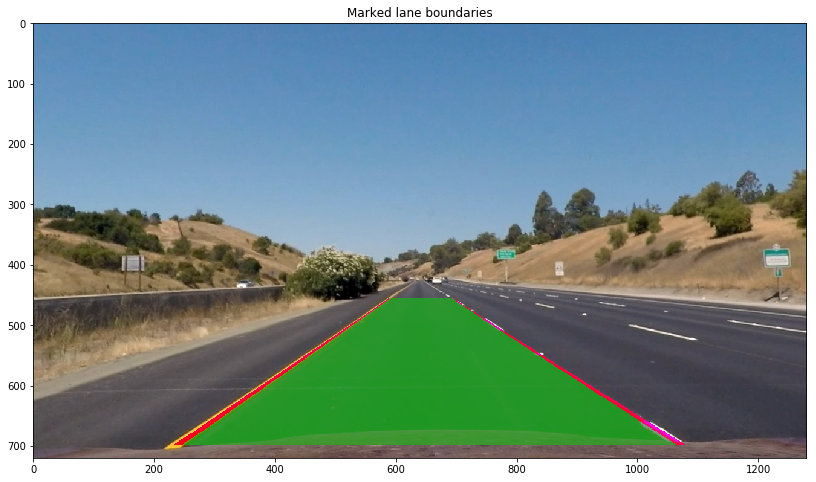

In [25]:
plt.figure(figsize=figsize)
img7 = mark_unwarped_lane(img_undistorted, M_perspective_transform, left_lane_x, left_lane_y, right_lane_x, right_lane_y)
font = cv2.FONT_HERSHEY_SIMPLEX
R=(R_left+R_right)/2
#cv2.putText(img7,'Radius of curvature %0.0fm' % (R),(10,50), font, 1.5,(255,255,255),2,cv2.LINE_AA)
#cv2.putText(img7,'Vehicle is %0.2fm of center' % (x_car_pos*xm_per_pix),(10,100), font, 1.5,(255,255,255),2,cv2.LINE_AA)
plt.imshow(img7)
plt.title('Marked lane boundaries')
#plt.savefig('./output_images/test.jpg')

## 3 Apply pipeline to all images

In [26]:
# Lane class
class Line():
    def __init__(self, alpha=0.2):
        # udpate weight for exponential average
        self.alpha=alpha               
        #average x values of the fitted line over the last n iterations
        self.best_x = None     
        self.best_y = None     
        #polynomial coefficients averaged over the last n iterations
        #self.best_fit = None          
        self.curvature = None
        #radius of curvature of the line in some units
        self.intercept_x = None

In [27]:
def pipeline(image, M_perspective_transform, ym_per_pix = 3/90, xm_per_pix =  3.7/635,
             
             output_intermediate_image=False,
             curvature_threshold =2,
             slope_threshold = 1,
             lane_left=None,
             lane_right=None):
    # pipeline to identify and mark lanes
    
    # 1 camera calibration
    image_undistorted = pipline_undistort(image)
    
  
    # 2 lane pixel identification
    if output_intermediate_image:
        image_binary, image_illustration, image_binary_B, image_binary_L = lane_pixel_detection(image_undistorted,
                                                                                                intermediate_image=True)
    else:
        image_binary = lane_pixel_detection(image_undistorted,
                                            intermediate_image=False)
    # 3 perspective transform
    #if output_intermediate_image:
    #    image_warped = cv2.warpPerspective(image_undistorted, M_perspective_transform, (image_undistorted.shape[1], image_undistorted.shape[0]))                                    
    image_warped_binary = cv2.warpPerspective(image_binary, M_perspective_transform, (image_binary.shape[1], image_binary.shape[0])) 
    
    # 4 lane center pixel identification        
    if (lane_left is None) or (lane_left.best_x is None):
        window_center_y, window_center_x = get_lane_pixel_mask(image_warped_binary[:, 0:int(image_warped_binary.shape[1]/2)],
                                                               threshold=100)
    else:        
        window_center_y = lane_left.best_y.copy().astype(int)
        window_center_x = lane_left.best_x.copy().astype(int)        
    left_y, left_x = get_pixel_index(image_warped_binary[:, 0:int(image_warped_binary.shape[1]/2)],
                                     window_center_y, window_center_x)
    
    
    if (lane_right is None) or (lane_right.best_x is None):
        window_center_y, window_center_x = get_lane_pixel_mask(image_warped_binary[:, int(image_warped_binary.shape[1]/2):],
                                                               threshold=100)
        window_center_x+=int(img_warped_binary.shape[1]/2)
    else:        
        window_center_y = lane_right.best_y.copy().astype(int)
        window_center_x = lane_right.best_x.copy().astype(int) 
    right_y, right_x = get_pixel_index(image_warped_binary[:, int(image_warped_binary.shape[1]/2):],
                                       window_center_y, window_center_x-int(img_warped_binary.shape[1]/2),
                                       x_offset=int(img_warped_binary.shape[1]/2))
    
    # 5 lane fitting and curvature
    R_left, slope_left, left_lane_y, left_lane_x, left_lane_pos, left_coefs = calc_curvature(left_x, left_y)
    R_right, slope_right, right_lane_y, right_lane_x, right_lane_pos, right_coefs = calc_curvature(right_x, right_y)
    

    # 6 check fit result
    curvature_ratio = abs(R_left - R_right)/np.sqrt(R_left)/np.sqrt(R_right)
    slope_diff = abs(slope_left-slope_right)
    bad_detection = (curvature_ratio >= curvature_threshold) or (slope_diff >=slope_threshold)
    
    # update
    if bad_detection:
        if lane_left is not None:
             if lane_left.best_x is None:
                best_left_lane_pos = lane_left.intercept_x
                best_R_left = lane_left.curvature
                best_left_lane_x = lane_left.best_x.copy().astype(int)
                best_left_lane_y = lane_left.best_y.copy().astype(int) 
    best_left_lane_pos = left_lane_pos
    best_right_lane_pos = right_lane_pos
    best_R_left = R_left
    best_R_right = R_right
    best_left_lane_x = left_lane_x
    best_left_lane_y = left_lane_y 
    best_right_lane_x = right_lane_x
    best_right_lane_y = right_lane_y
    
    if lane_left is not None:
        if not bad_detection:
            if lane_left.best_x is None:            
                lane_left.best_x = left_lane_x
                lane_left.best_y = left_lane_y
                lane_left.curvature = R_left
                lane_left.intercept_x = left_lane_pos
            else:
                lane_left.best_x = lane_left.alpha * left_lane_x + (1-lane_left.alpha) * lane_left.best_x
                lane_left.best_y = lane_left.alpha * left_lane_y + (1-lane_left.alpha) * lane_left.best_y
                lane_left.curvature = lane_left.alpha * R_left + (1-lane_left.alpha) * lane_left.curvature
                lane_left.intercept_x = lane_left.alpha * left_lane_pos + (1-lane_left.alpha) * lane_left.intercept_x
        best_left_lane_pos = lane_left.intercept_x
        best_R_left = lane_left.curvature
        best_left_lane_x = lane_left.best_x.copy().astype(int)
        best_left_lane_y = lane_left.best_y.copy().astype(int)         
         
            
    if lane_right is not None:
        if not bad_detection:
            if lane_right.best_x is None:
                lane_right.best_x = right_lane_x
                lane_right.best_y = right_lane_y
                lane_right.curvature = R_right
                lane_right.intercept_x = right_lane_pos
            else:
                lane_right.best_x = lane_right.alpha * right_lane_x + (1-lane_right.alpha) * lane_right.best_x
                lane_right.best_y = lane_right.alpha * right_lane_y + (1-lane_right.alpha) * lane_right.best_y
                lane_right.curvature = lane_right.alpha * R_right + (1-lane_right.alpha) * lane_right.curvature
                lane_right.intercept_x = lane_right.alpha * right_lane_pos + (1-lane_right.alpha) * lane_right.intercept_x
        best_right_lane_pos = lane_right.intercept_x
        best_R_right = lane_right.curvature
        best_right_lane_x = lane_right.best_x.copy().astype(int)
        best_right_lane_y = lane_right.best_y.copy().astype(int)   
            
    x_car_pos = image_warped_binary.shape[1]/2 - (best_left_lane_pos+best_right_lane_pos)/2
    R=(best_R_left+best_R_right)/2
    
    if output_intermediate_image:
        image_lane_identified= np.zeros_like(image)
        image_lane_identified[left_y[(left_x<image.shape[1])&(left_x>=0)],
                              left_x[(left_x<image.shape[1])&(left_x>=0)], 0]=255
        image_lane_identified[right_y[(right_x<image.shape[1])&(right_x>=0)],
                              right_x[(right_x<image.shape[1])&(right_x>=0)], 2]=255
        image_lane_identified[left_lane_y[(left_lane_x<image.shape[1])&(left_lane_x>=0)],
                              left_lane_x[(left_lane_x<image.shape[1])&(left_lane_x>=0)], :]=255        
        image_lane_identified[right_lane_y[(right_lane_x<image.shape[1])&(right_lane_x>=0)],
                              right_lane_x[(right_lane_x<image.shape[1])&(right_lane_x>=0)], :]=255


    # 6 mark lanes
    #image_warped_with_lane = cv2.cvtColor(image_warped_binary, cv2.COLOR_GRAY2RGB)  
    if bad_detection:
        rgb_color = (255, 0, 128)
    else:
        rgb_color = (255, 0, 0)
    image_with_lane_marked =  mark_unwarped_lane(image_undistorted, M_perspective_transform,
                                                 best_left_lane_x,
                                                 best_left_lane_y,
                                                 best_right_lane_x,
                                                 best_right_lane_y,
                                                 rgb_color = rgb_color)
    cv2.putText(image_with_lane_marked,'Radius of curvature %0.0fm' % (R),(10,50), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image_with_lane_marked,'Vehicle is %0.2fm of center' % (x_car_pos*xm_per_pix),(10,100), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    if output_intermediate_image:
        return image_with_lane_marked, image_undistorted, image_binary, image_warped_binary, image_lane_identified, image_binary_B, image_binary_L
    else:
        return image_with_lane_marked
    

In [28]:
output_dir = './output_images/'
for filename in test_files:
    plt.figure(figsize=(20,24))
    img = mpimg.imread(test_dir + filename)
    img_with_lane_marked, img_undistorted, img_binary, img_warped_binary, img_lane_identified, image_binary_B, image_binary_L = pipeline(img,
                                                                                                         M_perspective_transform=M_perspective_transform,
                                                                                                         output_intermediate_image=True)
    
    cv2.imwrite(output_dir+ 'calibration_' + filename, cv2.cvtColor(img_undistorted, cv2.COLOR_RGB2BGR))
    cv2.imwrite(output_dir+ 'binary_' + filename, cv2.cvtColor(img_binary*255, cv2.COLOR_GRAY2BGR))
    cv2.imwrite(output_dir+ 'color_B_' + filename, cv2.cvtColor(cv2.cvtColor(img_undistorted, cv2.COLOR_RGB2LAB)[:,:,2],
                                                                cv2.COLOR_GRAY2BGR))
    cv2.imwrite(output_dir+ 'color_L_' + filename, cv2.cvtColor(cv2.cvtColor(img_undistorted, cv2.COLOR_RGB2LUV)[:,:,0],
                                                                cv2.COLOR_GRAY2BGR))
    cv2.imwrite(output_dir+ 'binary_B_' + filename, cv2.cvtColor(image_binary_B.astype(np.uint8)*255, cv2.COLOR_RGB2BGR))
    cv2.imwrite(output_dir+ 'binary_L_' + filename, cv2.cvtColor(image_binary_L.astype(np.uint8)*255, cv2.COLOR_RGB2BGR))
    cv2.imwrite(output_dir+ 'warped_binary_' + filename, cv2.cvtColor(img_warped_binary*255, cv2.COLOR_GRAY2BGR))
    cv2.imwrite(output_dir+ 'lane_' + filename, cv2.cvtColor(img_lane_identified, cv2.COLOR_RGB2BGR))
    cv2.imwrite(output_dir+ 'final_' + filename, cv2.cvtColor(img_with_lane_marked, cv2.COLOR_RGB2BGR))
   

## 4 Pipeline to a video

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
def process_image(image):
    output_image = pipeline(image, M_perspective_transform=M_perspective_transform, output_intermediate_image=False,
                            curvature_threshold =2,
                            slope_threshold = 1,
                            lane_left = lane_left_r,
                            lane_right = lane_right_r)
    return output_image

In [31]:
output_video = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)

In [32]:
lane_left_r = Line()
lane_right_r = Line()
output_clip = clip1.fl_image(process_image)
output_clip.write_videofile(output_video)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing audio in project_videoTEMP_MPY_wvf_snd.mp3


100%|█████████████████████████████████████| 1112/1112 [00:01<00:00, 855.71it/s]


[MoviePy] Done.
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [14:34<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 



In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))